### An example notebook on how to use the Eyetracking repo

This is copied from a recent driving session. In the driving sessions, each run includes an eyetracking calibration sequence at the beginning, and this notebook is written around this experiment structure.

For cases in which the calibration video is separate from the data video, see step 3.

Important classes in this package:
* `PupilFinder` (and child classes): handles finding the pupil in videos. Child classes implement different algorithms.
* `EyetrackingClibrator`: takes pupil traces and estimates a mapping from pupil location in video space to gaze location in screen space. It includes a `PupilFinder` field that does this.
* `Eyetracker`: an unfinished top level class that combines things and gets you things that you can get features from.

Full documentation can be found in the [Docs folder](./Docs/index.html) of this repo.

In [1]:
from Eyetracking import EyetrackingCalibrator, Eyetracker, TemplatePupilFinder, EyetrackingUtilities
import numpy
from skimage.transform import warp, AffineTransform
from skimage import io
import cv2
from glob import glob

Take a quick look at the video. We use this to define a sub-window in the video to search for the pupil, since runtime is directly proportional to the size of the search area.

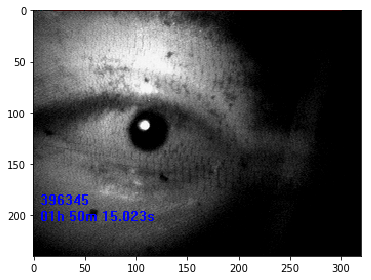

In [29]:
%matplotlib inline
video = cv2.VideoCapture('/E/Driving Data/20200814TZ/Eyetracking/run03.avi')
for i in range(300):
    r, f = video.read()
io.imshow(f)

In [8]:
# left, right, top, bottom
window = (25, 175, 80, 160)

To align the video to the TTLs, we make use of the history file saved by Avotec to find when the TTLs came in. Note that the time is burned into the eyetracking videos.

In [2]:
starts = EyetrackingUtilities.ParseHistoryForStartTTLs('/E/Driving Data/20200814TZ/Eyetracking/20200814TZ_history.txt')
for start in starts:
    print(start)

20 duplicated TTLs
((1, 17, 36, 381), 340)
((1, 34, 31, 689), 340)
((1, 50, 27, 354), 340)
((2, 10, 39, 394), 340)
((2, 26, 27, 251), 340)
(None, 0)
((2, 42, 17, 911), 340)


`ParseHistoryForStartTTLs` finds the first TTL in each run. It does so by looking for TTLs that are separated by a large amount of time. Because sometimes Avotec records spurious signals, the found set of TTLs may be a superset of the actual TTLs and may need to be pruned by hand, as in this case.

In [3]:
starts = [starts[i] for i in [0, 1, 2 ,3 ,4, 6]]
for start in starts:
    print(start)

((1, 17, 36, 381), 340)
((1, 34, 31, 689), 340)
((1, 50, 27, 354), 340)
((2, 10, 39, 394), 340)
((2, 26, 27, 251), 340)
((2, 42, 17, 911), 340)


In [4]:
eyetrackingFiles = glob('/E/Driving Data/20200814TZ/Eyetracking/run0*.avi')
eyetrackingFiles.sort()
eyetrackingFiles

['/E/Driving Data/20200814TZ/Eyetracking/run01.avi',
 '/E/Driving Data/20200814TZ/Eyetracking/run02.avi',
 '/E/Driving Data/20200814TZ/Eyetracking/run03.avi',
 '/E/Driving Data/20200814TZ/Eyetracking/run04.avi',
 '/E/Driving Data/20200814TZ/Eyetracking/run05.avi',
 '/E/Driving Data/20200814TZ/Eyetracking/run06.avi']

### Step 1: finding the pupils in the videos

Because I'm lazy, here's a function to deal with a video by run. The important class here is the `EyetrackingCalibrator.EyetrackingCalibrator` class. The arguments to this outer function, which are passed to the `FindPupils` method of the `EyetrackingCalibrator` class, are the 4 major parameters to  pupil finding process that will determine your success.

Important arguments to constructing an `EyetrackingCalibrator` in order in which they are used here:
* `(calibrationVideoFile): str?`: path to the eyetracking video file. This is nullable. You can pass it None and then use the Load method to load a saved calibration file, so you can skip the pupil finding process

* `(calibrationBeginTime): tuple<int, int, int, int>`: Timestamp in hours, minutes, seconds, milliseconds of the first TTL in the calibration video.

* `calibrationDelay: float`: number of seconds between the first TTL and the presentation
of the first calibration dot

* `calibrationDuration: float`: number of seconds that the subject fixates on
each calibration location

* `calibrationPositions: [n x 2] array`: pixel position of calibration locations on the screen. The GeneratePoints method will get you positions used in the standard eyetracking sequence.

* `calibrationOrder: List[int]`: the order in which the positions in calibrationPositions are presented to the subject. In the standard eyetracking sequence, each point is presented twice, and you should use EyetrackingCalibrator.CalibrationOrder70. In the driving experiment, I present each point only once because the calibration process is repeated in every run.

* `templates: bool`: Use the template matching method for finding the pupil? If false, it will use the [Hough transform](https://en.wikipedia.org/wiki/Hough_transform) to find an ellipse. That was the method we had historically used (by Shinji and Anwar, and also I think it's how Avotec finds the pupil location also), but I found that it is 1) much slower and 2) much noisier temporally than just convolving the video frame with a black circle on a white background (i.e. a pupil), and finding the position of max correlation. In the template matching method, the pupil size is found by using template circles of different sizes and picking the one with max correlation. This argument picks which `PupilFinder` class to spawn (different classes implement the two methods).

Note that this function I have here writes out a video with the pupil highlighted. You should also do this when processing eyetracking videos. Check the video to make sure that the pupil is correctly circled, since that will affect the gaze estimation process. The circle should not be jumping off the pupil. In some cases, it might be pushed off to one side and squeezed by the glint (because of the correlation maths) - that is fine, because that is a stationary bias that can be taken care of by the estimator. The circle jumping around can't be.

At the end of this step, the calibrator has only found where the pupil is. It has yet to estimate a gaze location.

Side note: if you look in the docstrings, I use `?` to denote a nullable argument. This was written before the Python3 switch and python2 does not have type annotations.

In [9]:
def FindPupils(run, blur = 7, minRadius = 15, maxRadius = 23, windowSize = 29):
    """
    Parses one run
    @param run:         int, run in the list of eyetracking files
    @param blur:        int, width of the median filter used to smooth the video before finding pupils
    @param minRadius:   int, lower bound on pupil radius to look for
    @param maxRadius:   int, upper bound on pupil radius to look for
    @param windowSize:  int, number of frames used to temporally smooth the pupil position
    """
    # Make the calibrator object. These arguments here are most likely the ones you will need to tweak
    calibrator = EyetrackingCalibrator.EyetrackingCalibrator(
        eyetrackingFiles[run], 
        starts[run][0], 
        calibrationDelay = 2.0, 
        calibrationDuration = 2.0,
        calibrationPositions = EyetrackingCalibrator.EyetrackingCalibrator.GeneratePoints(),
        calibrationOrder = EyetrackingCalibrator.EyetrackingCalibrator.CalibrationOrder35,
        templates = True)
    
    # Search the pupil in the video
    calibrator.FindPupils(window, blur = blur, minRadius = minRadius, maxRadius = maxRadius, windowSize = windowSize)
    
    # Write out a copy of the eyetracking video, with a circle drawn over the pupil
    calibrator.pupilFinder.WritePupilVideo('/E/Driving Data/20200814TZ/Eyetracking/run {} pupils.avi'.format(run + 1))
    return calibrator

#### Run 1

In [10]:
calibrator = FindPupils(0)

240x320 (HxW) video at 60.000240001 fps with 42389 frames


I checked the video and the gaze finding looks reasonable. 

## Step 2: Fit a mapping function that goes from pupil location to gaze location.
So here we actually estimate a mapping from the pupil positions in eyetracking video space to gaze location in screen space. I will spare you the details of the process. It's a radial basis function and think-plate spline interpolater, validated using a leave-one-out cross-validation process. You can look in the `EstimateClibrationPointPositions` method for details if you so wish.

Look at the `bestError` field of the `EyetrackingCalibrator` object after fitting. The is the leave-one-out error for each calibration point in which a mapping is trained on all the other points, and the pupil for the point is used to estimate gaze for that point. This is the number of pixels that the estimate is off by. Hand-wavy ranges for what this number should be:
* 0-20: fantastic
* 20-40: good
* 40-60: acceptable
* 60+: You need to tweak either the pupil finding parameters or information about the run (e.g. calibration delay, duration, time).

Arguments to the `Fit` method:
* `smoothnesses: List[float]`: RBF smoothnesses - you don't need to tweak this from the defaults.
* `methods: List[str]`: Interpolation methods - you don't need to tweak this from the defaults.
* `varianceThreshold: float?`: If provided, the calibrator looks at how steady the fixation is at each calibration point. Points above this threshold are not used. Empirically, leave this to None (default) if the videos are good.
* `glintVector: bool`: If true, uses the pupil-glint vector as the data, instead of just the pupil position. I empirically find this to be not helpful.
* `searchThreshold: float`: If the calibrator finds that `bestError` is above this value, it will search a larger range of `calibrationDelay` and `calibrationDuration` values, and set itself to the combination that returns the lowest error. Setting it to 0 diables this.

In [11]:
calibrator.EstimateCalibrationPointPositions()
calibrator.Fit()
calibrator.bestError

29.367180650467834

This saves out pupil locations, so you just load it back in later with `calibrator.Load('path-to-file')`. Because finding pupils takes a while.

In [12]:
calibrator.Save('/E/Driving Data/20200814TZ/Eyetracking/calibration 1.dat')

## Run 2

In [13]:
calibrator = FindPupils(1)

240x320 (HxW) video at 60.000240001 fps with 42326 frames


In [14]:
calibrator.FindPupils(window, blur = 11, minRadius = 15, maxRadius = 23, windowSize = 29)
calibrator.pupilFinder.WritePupilVideo('/E/Driving Data/20200814TZ/Eyetracking/run 2 pupils.avi')

In [15]:
calibrator.EstimateCalibrationPointPositions()
calibrator.Fit()
calibrator.bestError

20.432816300730064

Note in this run I had to tweak the blur size.

In [16]:
calibrator.Save('/E/Driving Data/20200814TZ/Eyetracking/calibration 2.dat')

I now spare you of looking at the other 4 runs, which are the same thing.

## Step 3: Get the eyetracking traces, and recenter stimulus frames to be retinotopic.
This is where we make the calibrator objects useful. Here we load a saved pupil location file to a new calibrator object, and does things with it.

There's a separate `Eyetracker` class. One day you won't have to deal with the `EyetrackingCalibrator` class anymore. The `Eyetracker` class handles a lot of meta things, like what if, unlike the driving experinment, you have the calibration video separate from the actual data videos?

#### Recentering frames
This process assumes you have individual frames saved out, or can loaded them into a numpy array. We build an `Eyetracker` object here. The important arguments to the constructor are:
* `calibrator: EyetrackingCalibrator`: this object has estimated a mapping from pupil location to gaze location using the calibraiton video
* `dataPupilFinder: PupilFinder`: this object has found the Pupil locations in your data video
* `dataStart: Tuple<int, int, int, int>`: Timestamp of first TTL in the data video
Note here, I just used the `pupilFinder` of the `calibrator` object, since in my experiment the calibration is in the data video. If it is separate, you will need to build a `PupilFinder` object, preferably of the `TemplatePupilFinder` class because it's faster and less noisy.

`Eyetracker.RecenterFrames` is fairly straightforward. The arguments are a numpy array of frames, and a folder of where to put them. Two other important arguments:
* `fps: int`: the framerate of your frames, which will most likely be different than the eyetracking videos
* `scale: float:` how big are these frames relative to the original 1024x768 screen resolution? Motion-energy is often calculated on scaled-down frames since the full resolution is overkill even for the smallest filter.

#### Getting gaze locations
You get out the pupil position in video space from a `PupilFinder` object using the `GetTraces` method. Since the videos being before the first TTL, there's a lot of excess fromes. The `PupilFinder` objects' `FindOnsetFrame` method takes a time stamp and gets you the frame index for that time. The 4 arguments are integers for hours, minutes, seconds, and milliseconds.

Then you give those traces to the `TransformToScreenCoordinates` method on the `EyetrackingCalibrator` object to get the corresponding gaze locations.

In [7]:
traces = []
for run in range(6):
    # note that I passed it None so the object doesn't load the eyetracking video.
    # this saves time and ram
    calibrator = EyetrackingCalibrator.EyetrackingCalibrator(None, 
                                 starts[run][0], calibrationDelay = 2.0, calibrationDuration = 2.0,
                                 calibrationPositions = EyetrackingCalibrator.EyetrackingCalibrator.GeneratePoints(),
                                 calibrationOrder = EyetrackingCalibrator.EyetrackingCalibrator.CalibrationOrder35,
                                 templates = True)
    # load a previously saved found pupil locations
    calibrator.Load('/E/Driving Data/20200814TZ/Eyetracking/calibration {}.dat'.format(run + 1))
    # we re-fit the mapper because that's quick (and also deterministic)
    calibrator.EstimateCalibrationPointPositions()
    calibrator.Fit()
    print(run)
    print(calibrator.bestError)
    
    # recenter frames
    frameFiles = glob('/E/Driving Data/20200814TZ/Frames/run {}/*'.format(run + 1))
    frameFiles.sort()
    frames = []
    for frame in range(len(frameFiles)):
        frames.append(io.imread(frameFiles[frame]))
    frames = numpy.array(frames)
    
    # the Eyetracker object takes the calibrator and does things to video frames with it.
    eyetracker = Eyetracker.Eyetracker(calibrator = calibrator, dataPupilFinder = calibrator.pupilFinder, 
                                       dataStart = starts[run][0])
    eyetracker.RecenterFrames(frames, '/E/Driving Data/20200814TZ/Frames Recentered/run {}/'.format(run + 1), fps = 30)
    
    # map pupil locations in video space to gaze positions in screen space.
    firstFrame = calibrator.pupilFinder.FindOnsetFrame(starts[run][0][0], starts[run][0][1], starts[run][0][2], starts[run][0][3])
    trace = calibrator.pupilFinder.GetTraces()[firstFrame:, :]
    traces.append(calibrator.TransformToScreenCoordinates(trace = trace))
    del calibrator

0
29.367180650467834
1
20.432816300730064
2
29.991116747192002
3
20.29448961124729
4
28.939680879466003
5
26.496719647262243


And now eyetracking videos have been processed.